In [1]:
cd ../src

c:\Users\fredl\Documents\Cours\M1 Androide\S2\ML\Projet\src


C:\Users\fredl\AppData\Roaming\Python\Python313\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from activation_func import TanH, Sigmoid, ReLU, Softmax, LogSoftmax
from module import Linear, Sequential, AutoEncoder
from loss import MSELoss, CrossEntropyLoss, BCELoss
from optimizers import Optim
from mltools import *

X = load_usps("../data/USPS_train.txt")
X = X[0]

encoder = Sequential(
    Linear(256, 100),
    TanH(),
    Linear(100, 10),
    TanH()
)
decoder = Sequential(
    Linear(10, 100),
    TanH(),
    Linear(100, 256),
    Sigmoid()
)
loss_fn = BCELoss()
autoencoder = AutoEncoder(encoder, decoder, loss_fn)


Epoch 0, Loss: 0.7615
Epoch 10, Loss: 1.0470
Epoch 20, Loss: 1.3767
Epoch 30, Loss: 1.6021
Epoch 40, Loss: 1.7700
Epoch 50, Loss: 1.9058
Epoch 60, Loss: 2.0224
Epoch 70, Loss: 2.1275
Epoch 80, Loss: 2.2261
Epoch 90, Loss: 2.3224


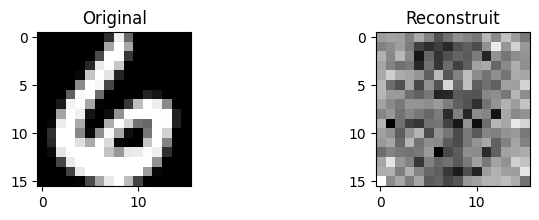

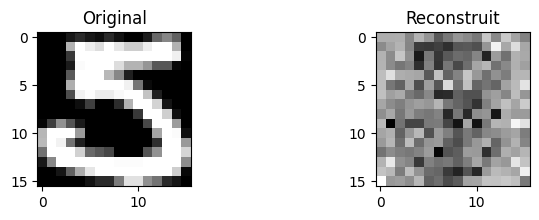

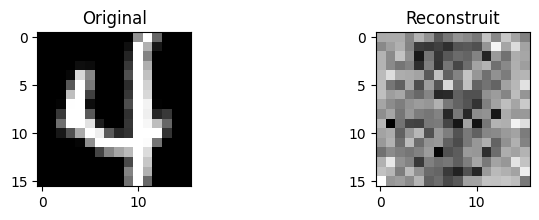

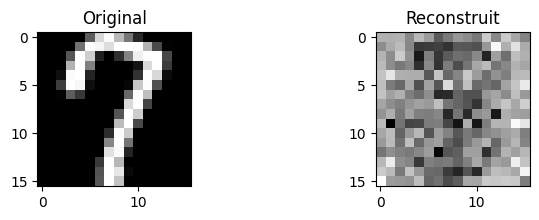

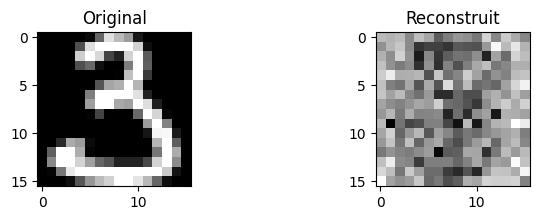

In [ ]:
def train_autoencoder(X, autoencoder, epochs=100, lr=0.01):
    for epoch in range(epochs):
        total_loss = 0
        autoencoder.zero_grad()
        out = autoencoder.forward(X)
        loss = autoencoder.loss_fn.forward(X, out)
        delta = autoencoder.loss_fn.backward(X, out)
        autoencoder.backward(delta, out)
        autoencoder.update_parameters(lr)
        total_loss += loss
        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

train_autoencoder(X, autoencoder)

X_reconstructed = autoencoder.forward(X)

# Visualisation de quelques reconstructions
for i in range(5):
    plt.figure(figsize=(8, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(X[i].reshape(16, 16), cmap="gray")
    plt.title("Original")
    plt.subplot(1, 2, 2)
    plt.imshow(X_reconstructed[i].reshape(16, 16), cmap="gray")
    plt.title("Reconstruit")
    plt.show()

# Les résultats sont bizarres, à voir pourquoi

KMeans clustering done. Labels: [2 0 6 0 4 8 0 4 0 5]


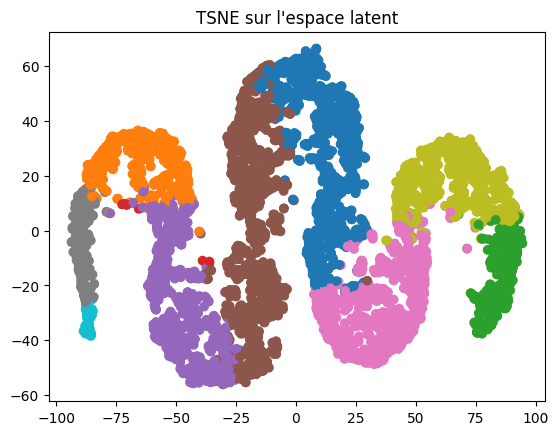

In [7]:
def get_latent_representation(X, model):
    out = X
    for layer in model.encoder.modules:
        out = layer.forward(out)
    return out

latent = get_latent_representation(X, autoencoder)

kmeans = KMeans(n_clusters=10, random_state=0).fit(latent)
labels = kmeans.labels_
print("KMeans clustering done. Labels:", labels[:10])

tsne = TSNE(n_components=2, random_state=0)
latent_2d = tsne.fit_transform(latent)
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='tab10')
plt.title("TSNE sur l'espace latent")
plt.show()

Epoch 0, Loss: 4.3869
Epoch 10, Loss: 4.7980
Epoch 20, Loss: 5.1333
Epoch 30, Loss: 5.3490
Epoch 40, Loss: 5.7194
Epoch 50, Loss: 5.9023
Epoch 60, Loss: 6.0690
Epoch 70, Loss: 6.2193
Epoch 80, Loss: 6.3236
Epoch 90, Loss: 6.4298


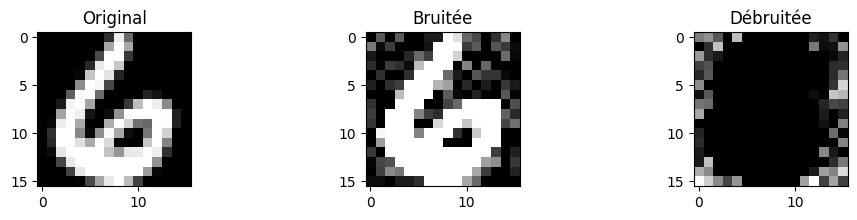

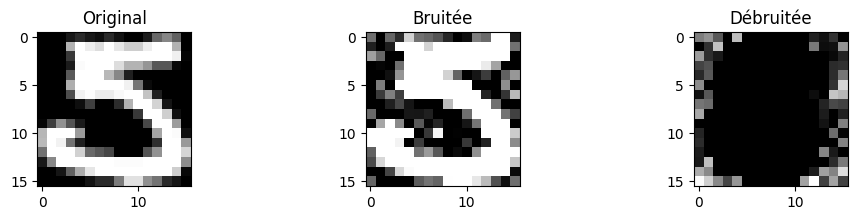

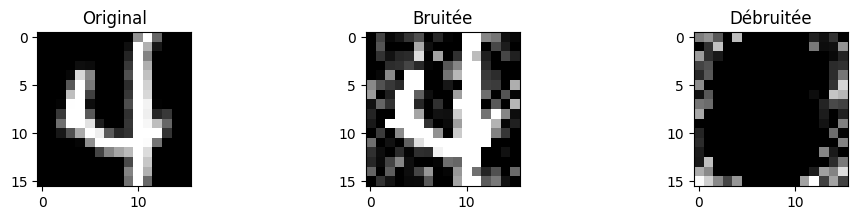

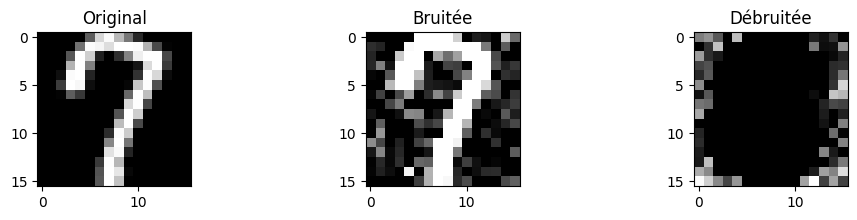

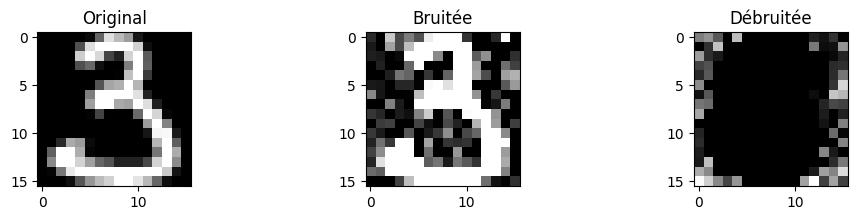

c:\Users\fredl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\fredl\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy on validation set: 0.2084
Accuracy on validation set (input space): 0.2132


ValueError: X has 255 features, but LogisticRegression is expecting 256 features as input.

In [10]:
X_noisy = X + 0.3 * np.random.normal(0, 1, X.shape)
X_noisy = np.clip(X_noisy, 0, 1)

train_autoencoder(X_noisy, autoencoder, epochs=100, lr=0.01)
X_denoised = autoencoder.forward(X_noisy)

for i in range(5):
    plt.figure(figsize=(12, 2))
    plt.subplot(1, 3, 1)
    plt.imshow(X[i].reshape(16, 16), cmap="gray")
    plt.title("Original")
    plt.subplot(1, 3, 2)
    plt.imshow(X_noisy[i].reshape(16, 16), cmap="gray")
    plt.title("Bruitée")
    plt.subplot(1, 3, 3)
    plt.imshow(X_denoised[i].reshape(16, 16), cmap="gray")
    plt.title("Débruitée")
    plt.show()

# Classification supervisée sur l'espace latent
X_test = load_usps("../data/USPS_test.txt")
X_test = X_test[0]
y_test = X_test[:, -1].astype(int)
X_test = X_test[:, :-1]
X_test = X_test / 255.0

X_train, X_val, y_train, y_val = train_test_split(X, labels, test_size=0.2, random_state=42)
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

X_train_latent = get_latent_representation(X_train, autoencoder)
X_val_latent = get_latent_representation(X_val, autoencoder)
# X_test_latent = get_latent_representation(X_test, autoencoder)

model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
model.fit(X_train_latent, y_train)
y_pred = model.predict(X_val_latent)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set: {accuracy:.4f}")
# y_test_pred = model.predict(X_test_latent)
# accuracy_test = accuracy_score(y_test, y_test_pred)
# print(f"Accuracy on test set: {accuracy_test:.4f}")
# plt.scatter(X_test_latent[:, 0], X_test_latent[:, 1], c=y_test, cmap='tab10')
# plt.title("Classification sur l'espace latent")
# plt.show()

# Classification supervisée sur l'espace d'entrée
model = LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, y_train)
y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy on validation set (input space): {accuracy:.4f}")
y_test_pred = model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"Accuracy on test set (input space): {accuracy_test:.4f}")
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='tab10')
plt.title("Classification sur l'espace d'entrée")
plt.show()